# ジョブ実行 with Azure ML

Python スクリプトとして作成した機械学習をジョブとして実行する場合の Azure ML の使用方法

![images/job.png](images/job.png)
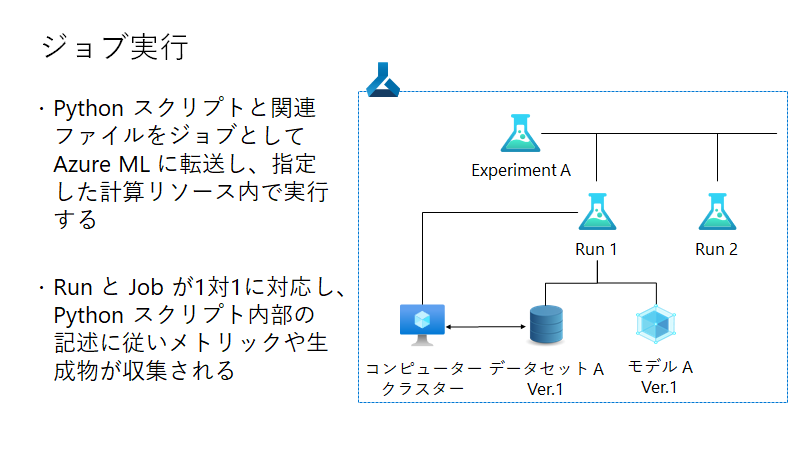

## Azure ML Workspace 接続

In [ ]:
from azureml.core import Workspace

subscription_id = "<id>" # 環境ごとに変更
resource_group = '<rg>' # 環境ごとに変更
workspace_name = '<ws>' # 環境ごとに変更

# 指定した Azure ML Workspace と紐づく Workspace インスタンスを作成
ws = Workspace(
        workspace_name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
    )

## データセットの取得orデータセットの加工・登録

In [ ]:
from azureml.core import Dataset, Datastore
from azureml.opendatasets import NycTlcGreen
import pandas as pd
import copy
from datetime import datetime
from dateutil.relativedelta import relativedelta

dataset_name = "nyc_taxi_dataset"

try:
    dataset = Dataset.get_by_name(ws, dataset_name)
    df = dataset.to_pandas_dataframe()
    
except:
    raw_df = pd.DataFrame([])
    start = datetime.strptime("1/1/2015","%m/%d/%Y")
    end = datetime.strptime("1/31/2015","%m/%d/%Y")
    
    for sample_month in range(3):
        temp_df_green = NycTlcGreen(start + relativedelta(months=sample_month), end + relativedelta(months=sample_month)) \
            .to_pandas_dataframe()
        raw_df = raw_df.append(temp_df_green.sample(2000))
    
    raw_df.head(10)
    
    df = copy.deepcopy(raw_df)

    columns_to_remove = ["lpepDropoffDatetime", "puLocationId", "doLocationId", "extra", "mtaTax",
                         "improvementSurcharge", "tollsAmount", "ehailFee", "tripType", "rateCodeID",
                         "storeAndFwdFlag", "paymentType", "fareAmount", "tipAmount"
                        ]
    for col in columns_to_remove:
        df.pop(col)  
    
    df = df.query("pickupLatitude>=40.53 and pickupLatitude<=40.88")
    df = df.query("pickupLongitude>=-74.09 and pickupLongitude<=-73.72")
    df = df.query("tripDistance>=0.25 and tripDistance<31")
    df = df.query("passengerCount>0 and totalAmount>0")
    
    df["lpepPickupDatetime"] = df["lpepPickupDatetime"].map(lambda x: x.timestamp())
    
    datastore = Datastore.get_default(ws)
    dataset = Dataset.Tabular.register_pandas_dataframe(df, datastore, dataset_name)
    
df.head(5)

## ジョブを実行する環境の定義

conda の環境定義、pip の要求パッケージリス尾、Dockerfile のいずれかを使用して Environment を作成する。Environment として定義された環境は使用時にコンテナとしてビルドされ、コンピューティングインスタンス/クラスターに転送される。

ジョブの初回実行時はコンテナビルドのため実行時間が伸びるが、2回目以降の実行はキャッシュされたコンテナを使用するため高速に実行される。

In [ ]:
from azureml.core import Environment

environment_name = "lightgbm-python-env"
# 事前に用意した conda のパッケージ依存リストを使用して作成する
file_path = "src/conda_env.yml"
env = Environment.from_conda_specification(name = environment_name, file_path = file_path)
env.register(ws)

## ジョブの定義

ジョブの実行は Run と関連付けられ、Expriment によって複数個の Run を管理する。

In [ ]:
from azureml.core import Experiment

experiment_name = "job_nyc_taxi_lightgbm_regression"
experiment = Experiment(ws, experiment_name)

ジョブを実行するコンピューティングリソース、実行する Python スクリプトと周辺ファイル群、与える引数、使用する環境を定義する。

In [ ]:
from azureml.core import ScriptRunConfig

script_dir = "src"
script_name = "taxi_lightgbm_regression.py"
compute_name = "cpu-clus01" # 環境ごとに変更

args = [
    "--input-data", dataset.as_named_input("nyc_taxi_dataset"),
    '--boosting_type', 'gbdt',
    '--metric', 'rmse',
    '--learning_rate', 0.1,
    '--num_leaves', 10,
    '--min_data_in_leaf', 1,
    '--num_iteration', 100,
]

src = ScriptRunConfig(
    # 指定したディレクトリを丸ごと転送する
    source_directory=script_dir,
    # ディレクトリに含まれる実行スクリプトを指定する
    script=script_name,
    # ジョブを実行する Environment を指定する
    environment=env,
    # 実行スクリプトに与える引数を指定する
    arguments=args,
    # ジョブを実行するコンピューティングリソースを指定する
    compute_target=compute_name,
)

## ジョブ実行

対話的な実験において使用した「実験記録を取るためのオブジェクト」としての Run と性質が異なり、ジョブ実行においてはジョブが Run と対応し、Run を submit することでジョブの実行が開始される。

指定した Python スクリプト内で各種実験記録を取った場合、ジョブと対応する Run に記録される。

In [ ]:
run = experiment.submit(src)
run.wait_for_completion(show_output=True)

## モデル登録

In [ ]:
model = run.register_model(
    model_name="lgb-model",
    model_framework="LightGBM",
    model_framework_version="3.3.2",
    tags={'algorithm': 'lightGBM'}, 
    model_path = 'outputs/')